In [1]:
#Importación de las librerías necesarias 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
plt.style.use('fivethirtyeight') # For plots

Importing plotly failed. Interactive plots will not work.


In [2]:
'''Lectura de los datos, en este caso se utilizó la descarga de los datos del Sensor 50555 
directamente desde supabase hasta el 16 de julio a las 2:00 p.m.
El archivo fue modificado manualmente para eliminar las columnas innecesarias y para reordenar las dos columnas presentadas,
Es importante que la primera columna sean las fechas y la segunda la concentración de pm 2.5'''
pjme = pd.read_csv('sensor_50555.csv',dayfirst=True,
                   index_col=[0], parse_dates=[0]) # We set the index column to the dates 


In [3]:
pjme

,pm25
time_stamp,
2023-07-20 00:04:00,12.4
2023-07-20 01:04:00,13.0
2023-07-20 02:04:00,13.0
2023-07-20 03:04:00,12.9
2023-07-20 04:01:00,12.8
...,...
2024-07-23 19:01:00,9.9
2024-07-23 20:00:00,8.2
2024-07-23 21:01:00,7.4


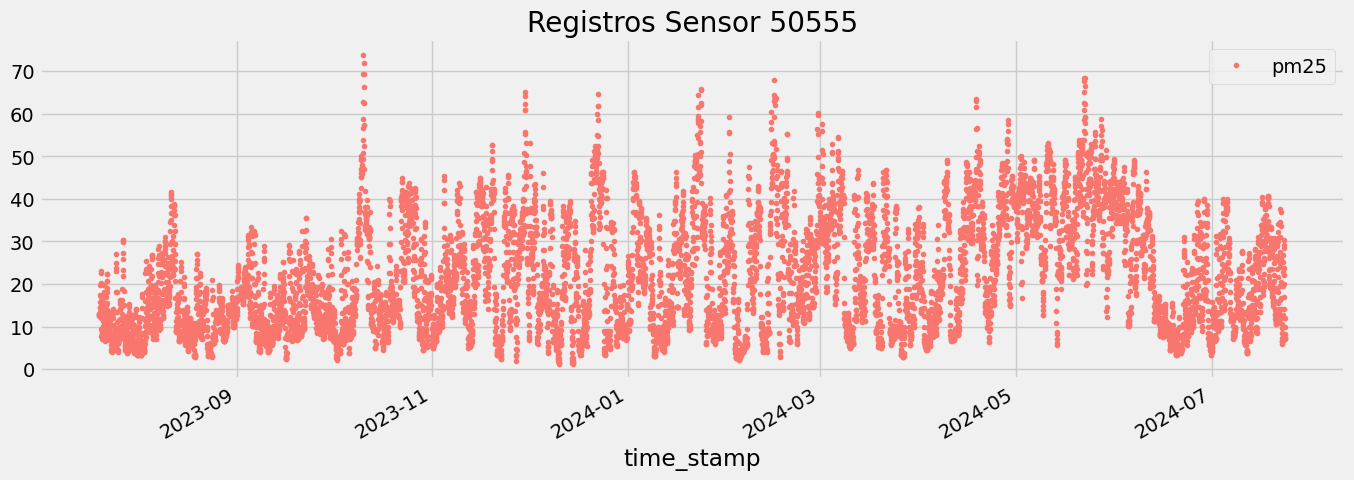

In [4]:
#Visualización de los datos
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='Registros Sensor 50555')
plt.show()

In [5]:
#Creación de un formato exploratorio para la serie de tiempo
def create_features(df, label=None):
    """
    Creates time series features from time_stamp index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='pm25')

features_and_target = pd.concat([X, y], axis=1)

In [6]:
# See our features and target
features_and_target.tail()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,pm25
time_stamp,,,,,,,,,
2024-07-23 19:01:00,19,1,3,7,2024,205,23,30,9.9
2024-07-23 20:00:00,20,1,3,7,2024,205,23,30,8.2
2024-07-23 21:01:00,21,1,3,7,2024,205,23,30,7.4
2024-07-23 22:00:00,22,1,3,7,2024,205,23,30,7.3
2024-07-23 23:00:00,23,1,3,7,2024,205,23,30,7.0


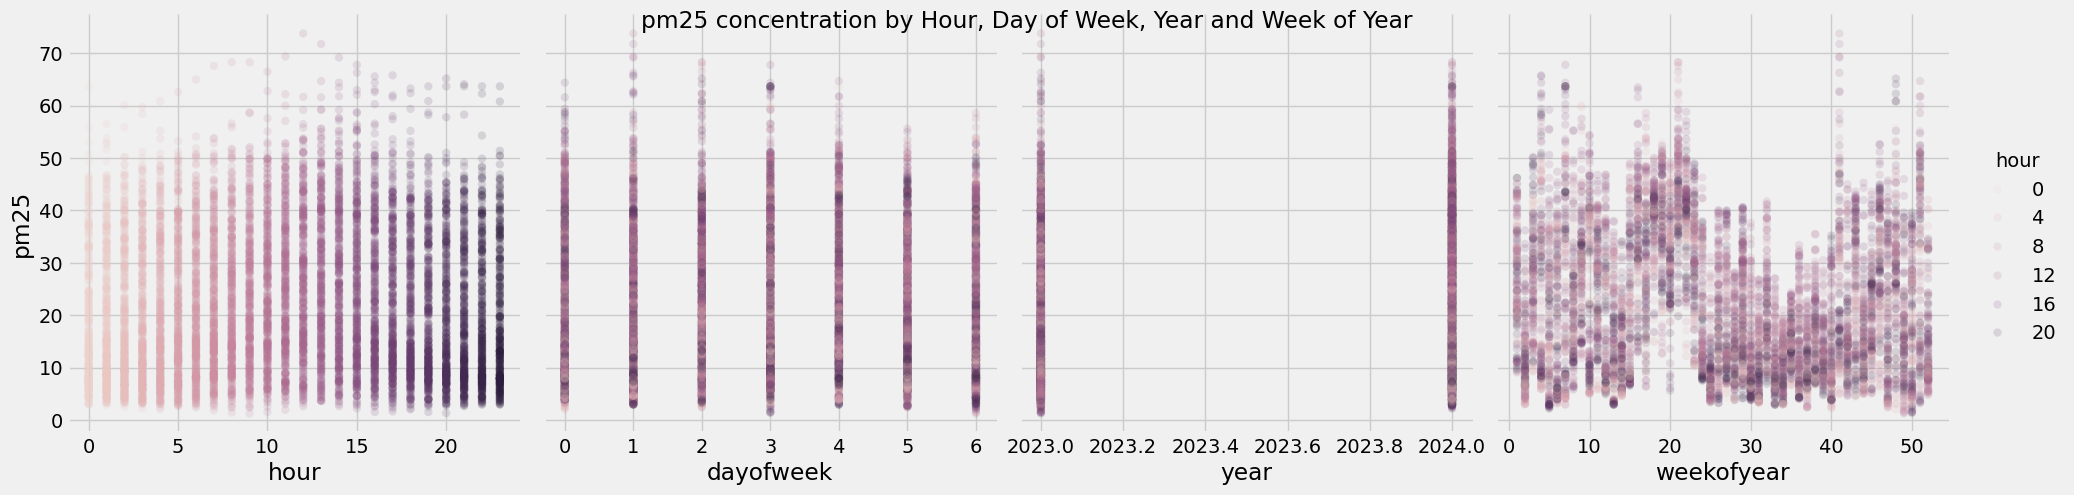

In [7]:
#Visualización de los datos 
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='pm25',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('pm25 concentration by Hour, Day of Week, Year and Week of Year')
plt.show()

In [8]:
#Se define la cantidad de datos de entrenamiento y testeo
split_date = '01-Jul-2024'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

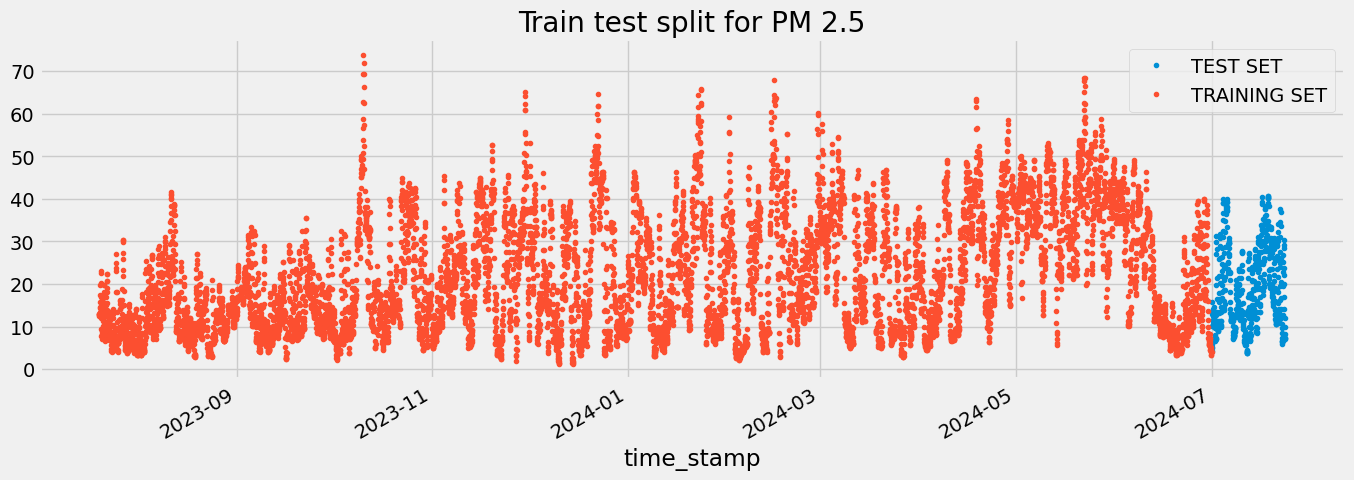

In [9]:
# Grafico de la división de datos en entrenamiento y testeo
pjme_test \
    .rename(columns={'pm25': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'pm25': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='Train test split for PM 2.5', style='.')
plt.show()

In [10]:
# Formateo de los datos al formato especificado por la librería de Prophet
pjme_train.reset_index() \
    .rename(columns={'time_stamp':'ds',
                     'pm25':'y'}).head()

,ds,y
0,2023-07-20 00:04:00,12.4
1,2023-07-20 01:04:00,13.0
2,2023-07-20 02:04:00,13.0
3,2023-07-20 03:04:00,12.9
4,2023-07-20 04:01:00,12.8


Facebook Prophet es una librería de código abierto desarrollada por Facebook para la predicción de series temporales univariadas. Está diseñada para ser fácil de usar y automatizar el proceso de ajuste de hiperparámetros, lo que la hace accesible incluso para usuarios sin experiencia en estadística.
*
Características principale*s* :
Modelo aditivo: Prophet utiliza un modelo aditivo que permite ajustar tendencias no lineales con estacionalidades anuales, semanales y diarias, además de efectos de días festios* 1.
Automatización: La librería está diseñada para ser completamente automática. Solo necesitas proporcionar una serie temporal y Prophet se encarga del rsarn2.

In [11]:
#Segunda iteración del moelo: Se usa la función que determina cambios en la tendencia. Este modelo fue capaz de predecir valores 
#de "Mala" calidad en el aire

10:51:14 - cmdstanpy - INFO - Chain [1] start processing
10:51:14 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\asgar\anaconda3\envs\tecmx\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\asgar\anaconda3\envs\tecmx\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


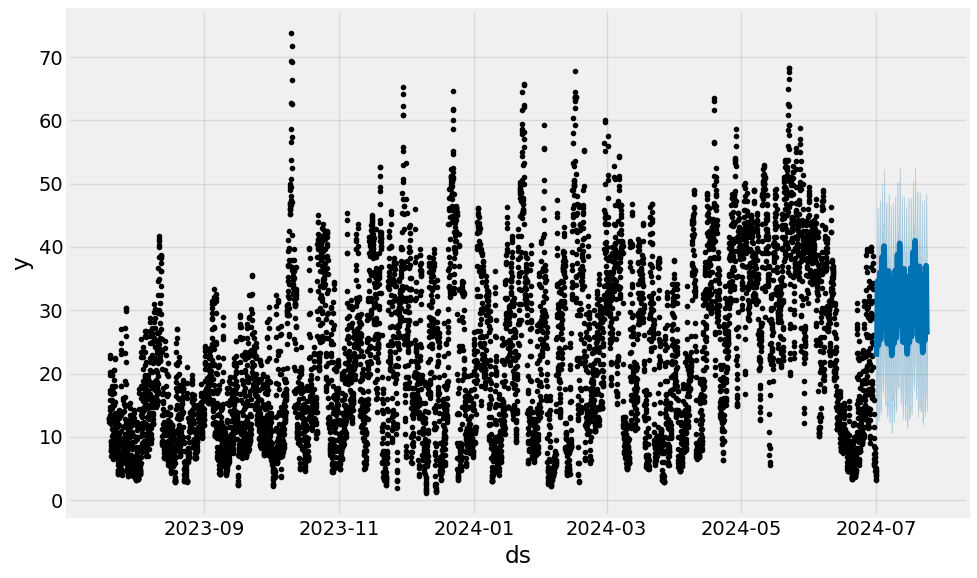

In [12]:
# Entrenamiento y gráfico del modelo 
m= Prophet(changepoint_prior_scale=0.001, interval_width=0.65, seasonality_prior_scale=5, seasonality_mode='multiplicative')
forecast=m.fit(pjme_train.reset_index() \
              .rename(columns={'time_stamp':'ds',
                               'pm25':'y'})).predict(df=pjme_test.reset_index() \
                                   .rename(columns={'time_stamp':'ds'}))
fig = m.plot(forecast)

In [13]:
# Calculate RMSE
actual = pjme_test['pm25'].values
predicted = forecast['yhat'][:len(actual)].values
rmse = np.sqrt(mean_squared_error(actual, predicted))

print(f'RMSE: {rmse}')

RMSE: 13.359728020000588


In [15]:
#Visualización de la información entregada por el modelo
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2024-07-01 00:07:00,29.430411,11.228027,34.073915,29.430411,29.430411,-0.137947,-0.137947,-0.137947,-0.229842,-0.229842,-0.229842,-0.091895,-0.091895,-0.091895,0.0,0.0,0.0,22.666065
1,2024-07-01 01:01:00,29.432021,12.201930,34.434895,29.432021,29.432021,-0.131988,-0.131988,-0.131988,-0.223057,-0.223057,-0.223057,-0.091069,-0.091069,-0.091069,0.0,0.0,0.0,22.867000
2,2024-07-01 02:01:00,29.433811,11.103006,35.189027,29.433811,29.433811,-0.120677,-0.120677,-0.120677,-0.210508,-0.210508,-0.210508,-0.089831,-0.089831,-0.089831,0.0,0.0,0.0,23.237748
3,2024-07-01 03:00:00,29.435570,11.439111,36.069643,29.435570,29.435570,-0.106066,-0.106066,-0.106066,-0.194366,-0.194366,-0.194366,-0.088300,-0.088300,-0.088300,0.0,0.0,0.0,23.714300
4,2024-07-01 04:00:00,29.437359,12.797243,35.476849,29.437359,29.437359,-0.088733,-0.088733,-0.088733,-0.175178,-0.175178,-0.175178,-0.086444,-0.086444,-0.086444,0.0,0.0,0.0,24.280594


C:\Users\asgar\anaconda3\envs\tecmx\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\asgar\anaconda3\envs\tecmx\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


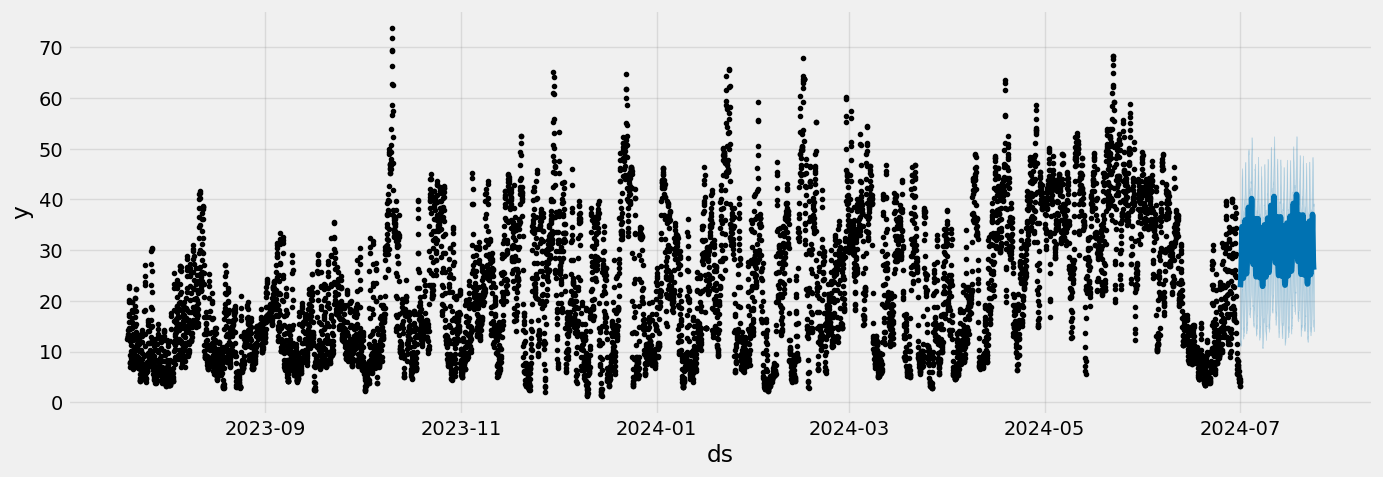

In [16]:
# Grafico con todos los datos históricos y los datos predichos 
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = m.plot(forecast,
                 ax=ax)
plt.show()

C:\Users\asgar\anaconda3\envs\tecmx\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\asgar\anaconda3\envs\tecmx\Lib\site-packages\prophet\plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
C:\Users\asgar\anaconda3\envs\tecmx\Lib\site-packages\prophet\plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarra

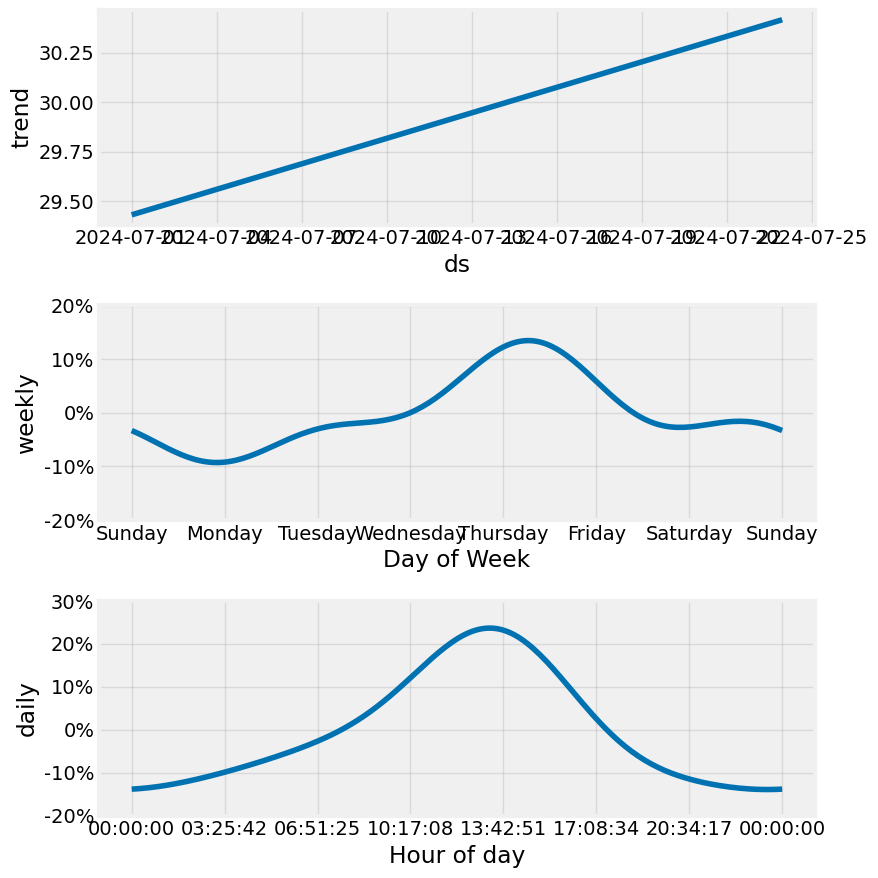

In [17]:
# Gráficos de los componentes del modelo: tendencias y distribuciones semanales y diarias de contaminantes
fig = m.plot_components(forecast)

C:\Users\asgar\anaconda3\envs\tecmx\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\asgar\anaconda3\envs\tecmx\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


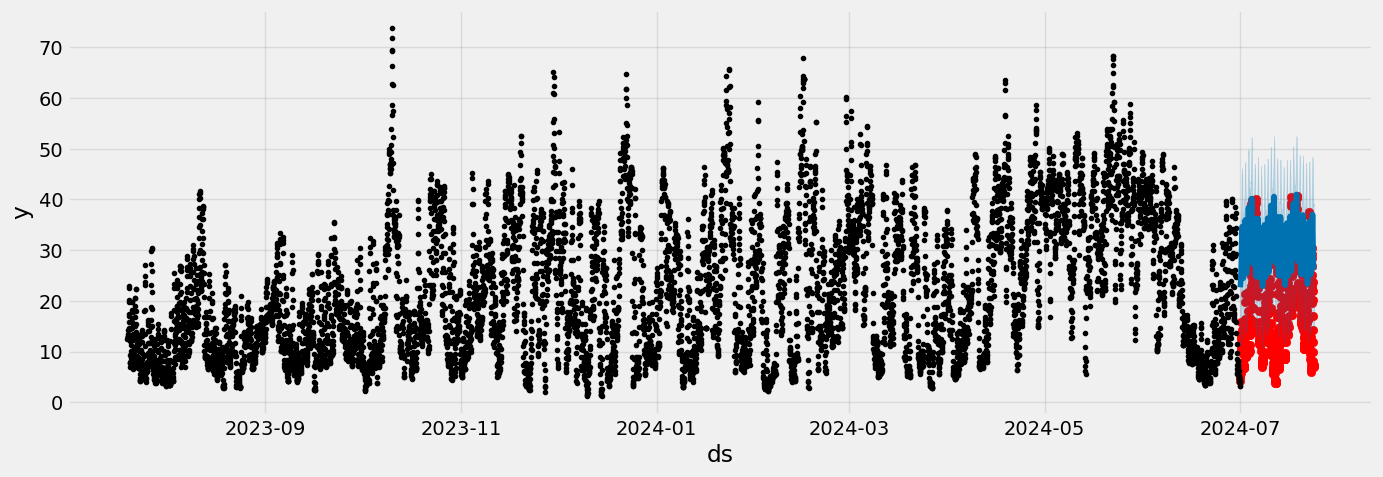

In [18]:
# Gráfica comparativa sobre el desempeño del modelo y los valores reales (testing phase) 
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['pm25'], color='r')
fig = m.plot(forecast, ax=ax)

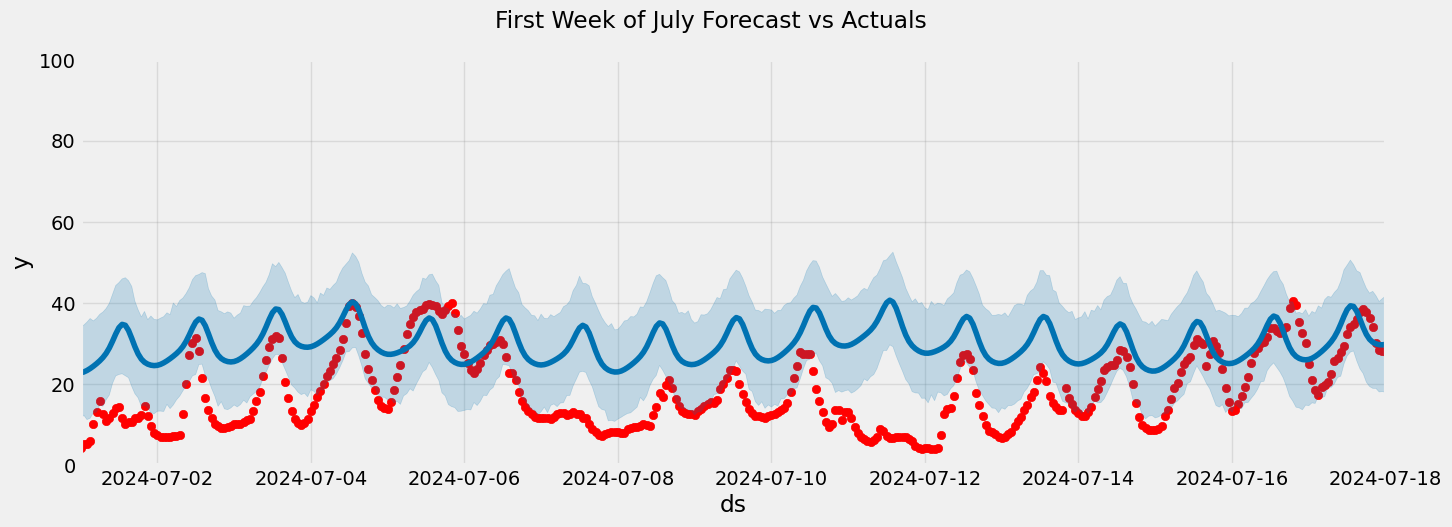

In [19]:
# Grafico comparativo del desempeño del modelo durante las fechas especificadas (en este caso durante 17 días)
start_date = pd.to_datetime('2024-07-01')
end_date = pd.to_datetime('2024-07-18')

# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['pm25'], color='r')
fig = m.plot(forecast, ax=ax)

# Set the x-axis limits
ax.set_xlim(start_date, end_date)
ax.set_ylim(0, 100)
plt.suptitle('First Week of July Forecast vs Actuals')

plt.show()

In [20]:
#Error medio cuadrado 
mean_squared_error(y_true=pjme_test['pm25'],
                   y_pred=forecast['yhat'])

178.48233276838886

In [21]:
#Error medio absoluto
mean_absolute_error(y_true=pjme_test['pm25'],
                   y_pred=forecast['yhat'])

11.508569557975719

In [22]:
#Error medio absoluto porcentual
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['pm25'],
                   y_pred=forecast['yhat'])

103.29663427183773

In [23]:
# Chunk utilizado para la extracción de los datos al archivo de sheets: Descarga el pronóstico arrojado en la fase de testeo
#selected_columns = forecast[['ds', 'yhat']]
#selected_columns.to_csv('FB_prophet_forecast0107-01.csv', index=False)

In [27]:
#Función utilizada para realizar predicciones reales a futuro 
def predict_future(m, start_date, end_date):
    # Crear un dataframe con las fechas futuras
    future_dates = pd.date_range(start=start_date, end=end_date, freq='h')
    future_df = pd.DataFrame({'ds': future_dates})
    
    # Realizar la predicción
    forecast = m.predict(future_df)
    
    return forecast

# Especificar las fechas de inicio y fin para la predicción
start_date = '2024-07-24 00:00:00'
end_date = '2024-07-25 00:00:00'

# Obtener la predicción
future_forecast = predict_future(m, start_date, end_date)
# Select the columns 'ds' and 'yhat'
selected_columns = future_forecast[['ds', 'yhat']]

# Export the selected columns to a CSV file
selected_columns.to_csv('FB_prophet_forecast0107-02.csv', index=False)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(selected_columns['ds'], selected_columns['yhat'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Prediction')
plt.title('Forecasted Values')
plt.legend()
plt.grid(True)
plt.show()